In [ ]:
! pip install cftime nc-time-axis

In [ ]:
! pip install --upgrade xarray zarr gcsfs cftime nc-time-axis

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
plt.rcParams['figure.figsize'] = 12, 6

In [ ]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [ ]:
df_tos = df.query("source_id=='UKESM1-0-LL'& experiment_id=='ssp126' & table_id == 'Omon' & variable_id == 'tos' & member_id=='r1i1p1f2'	")
df_tos

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
217819,ScenarioMIP,MOHC,UKESM1-0-LL,ssp126,r1i1p1f2,Omon,tos,gn,gs://cmip6/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/...,NaN,20190708


##Load data


In [ ]:
# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_tos.zstore.values[-1]

# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)
ds_g = xr.open_zarr(mapper, consolidated=True)

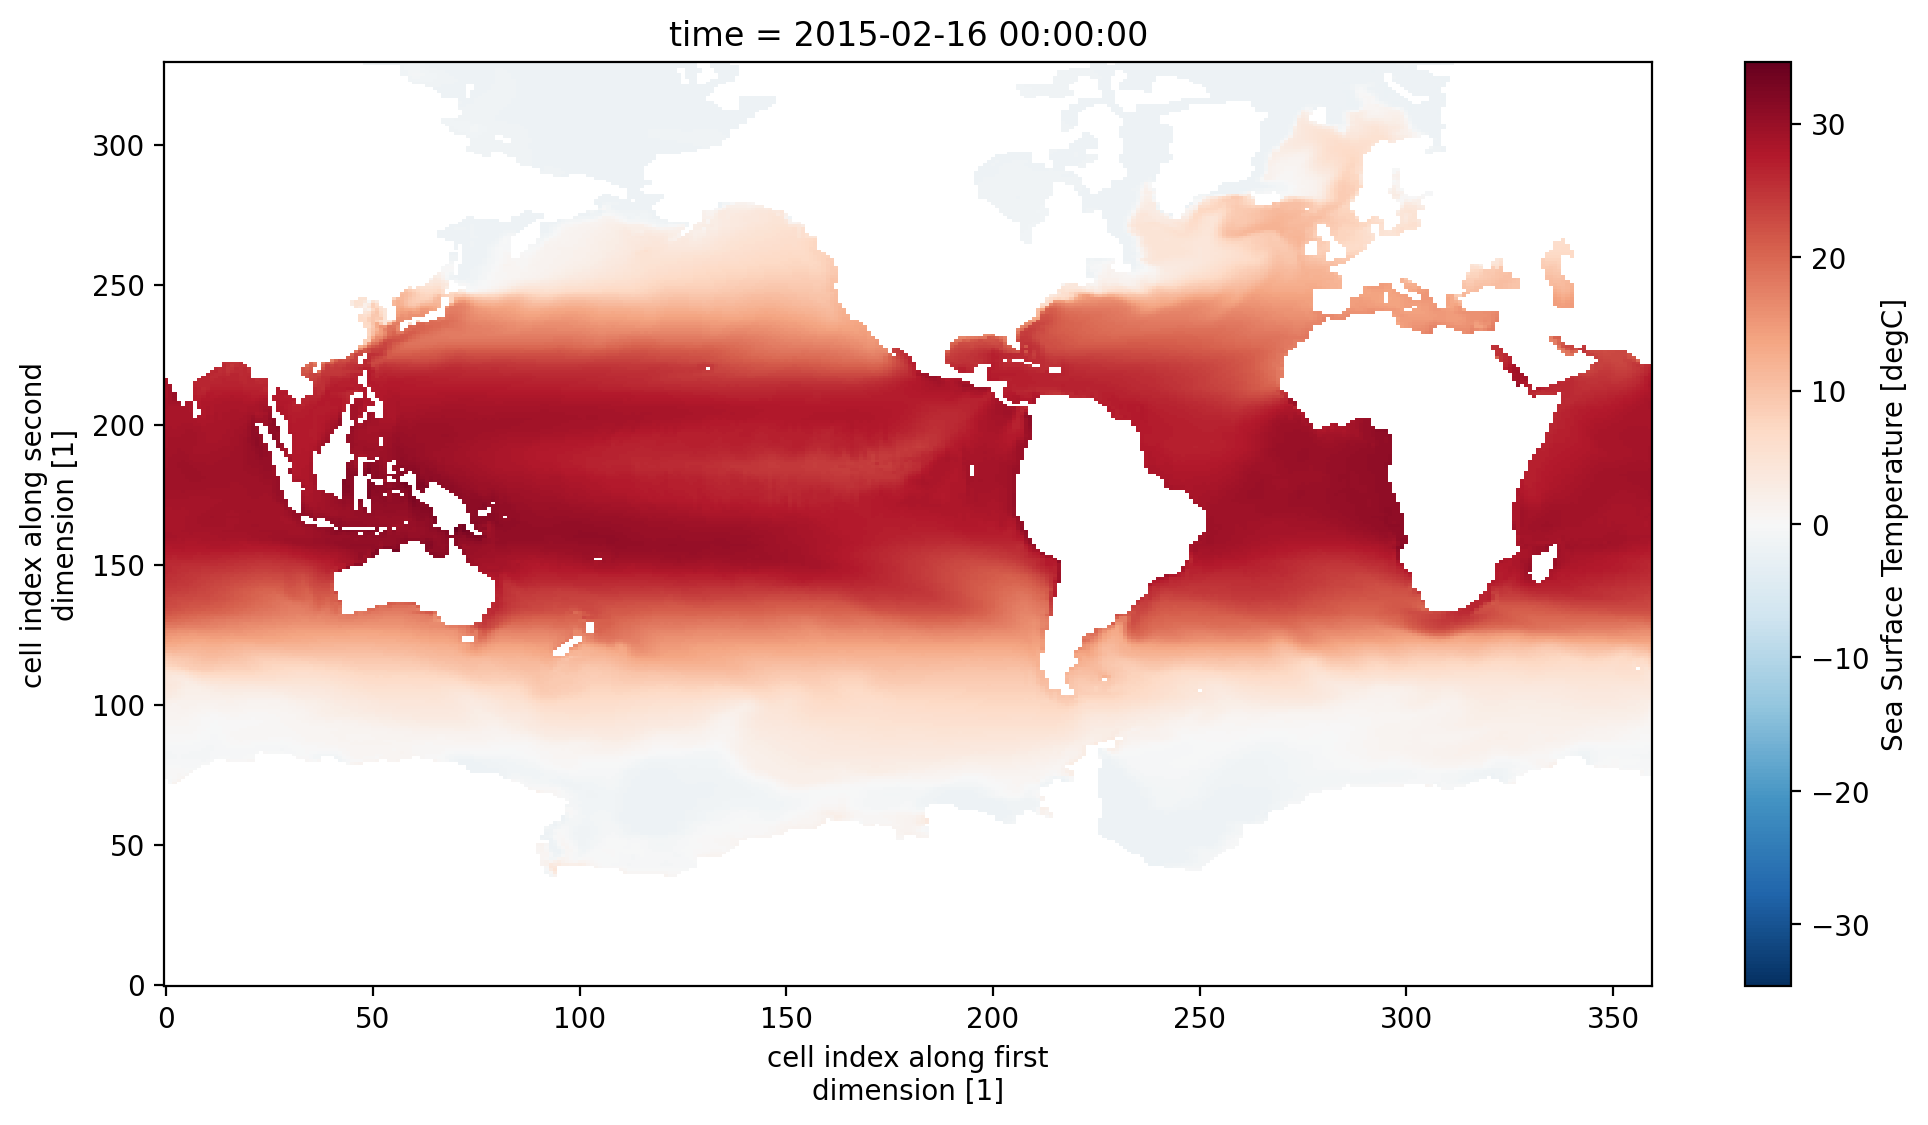

In [ ]:
ds.tos.sel(time=ds['time'][1]).squeeze().plot()

In [ ]:
ds['time']

<xarray.DataArray 'time' (time: 1032)>
array([cftime.Datetime360Day(2015, 1, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2015, 2, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2015, 3, 16, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.Datetime360Day(2100, 10, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2100, 12, 16, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time

#1st Step : Defining AMO

In [ ]:
df_area = df.query("variable_id == 'areacella' & source_id == 'UKESM1-0-LL'")
ds_area = xr.open_zarr(gcs.get_mapper(df_area.zstore.values[0]), consolidated=True)
df_area_g = df.query("variable_id == 'areacella' & source_id == 'UKESM1-0-LL'")
ds_area_g = xr.open_zarr(gcs.get_mapper(df_area.zstore.values[0]), consolidated=True)

In [ ]:
total_area = ds_area.areacella.sum(dim=['lon', 'lat'])
total_area_g = ds_area_g.areacella.sum(dim=['lon', 'lat'])
ds['tos_normalized'] = (ds_area.areacella * ds.tos ) / total_area
ds_g['tos_normalized'] = (ds_area_g.areacella * ds_g.tos ) / total_area_g

In [ ]:
ds['longitude'].min().compute()

<xarray.DataArray 'longitude' ()>
array(-179.99654, dtype=float32)

In [ ]:
ds1 =ds.where(ds['longitude']>=-80)
ds1 =ds1.where(ds1['latitude']<=60)
ds1 =ds1.where(ds1['latitude']>=0)
ds1 =ds1.where(ds1['longitude']<=0)

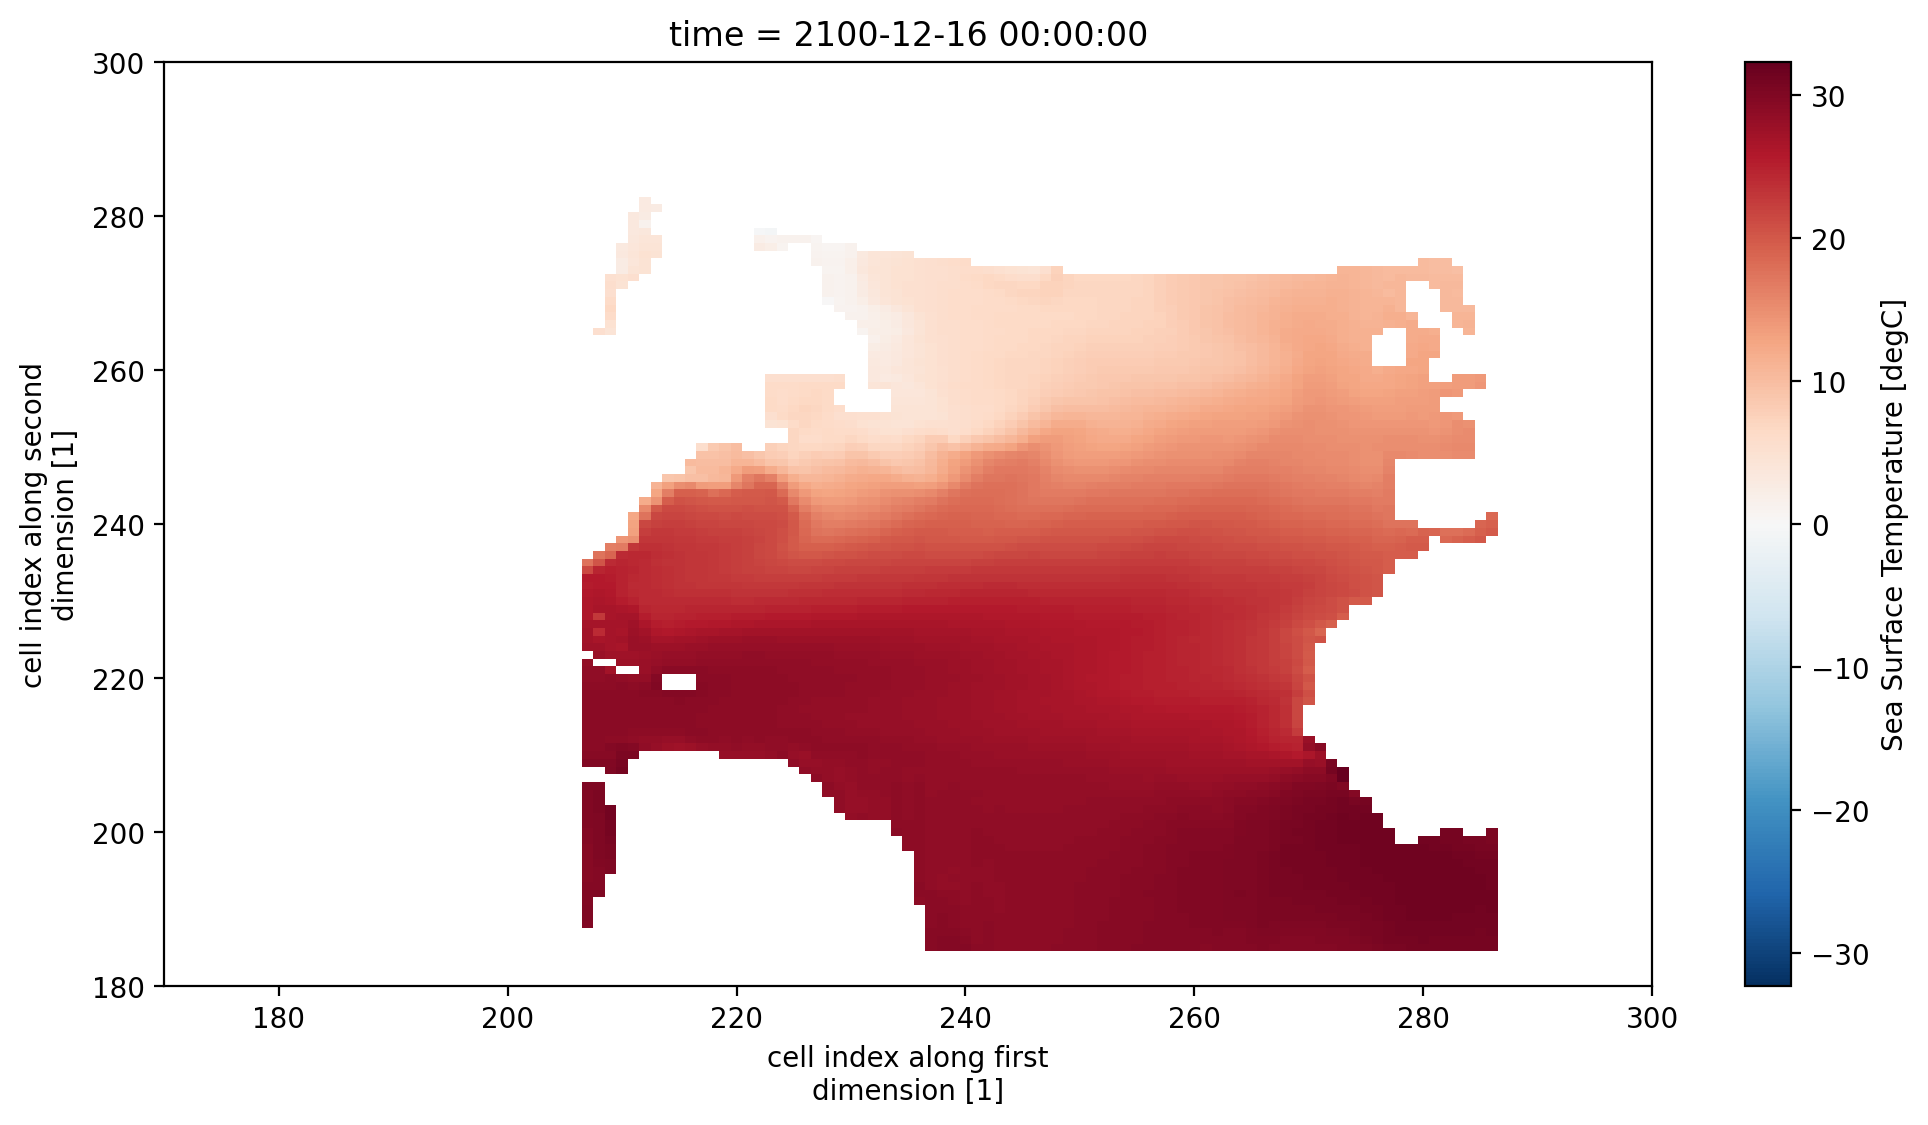

In [ ]:
ds1.tos.sel(time=ds1.time[-1]).squeeze().plot(xlim=(170, 300), ylim=(180,300))


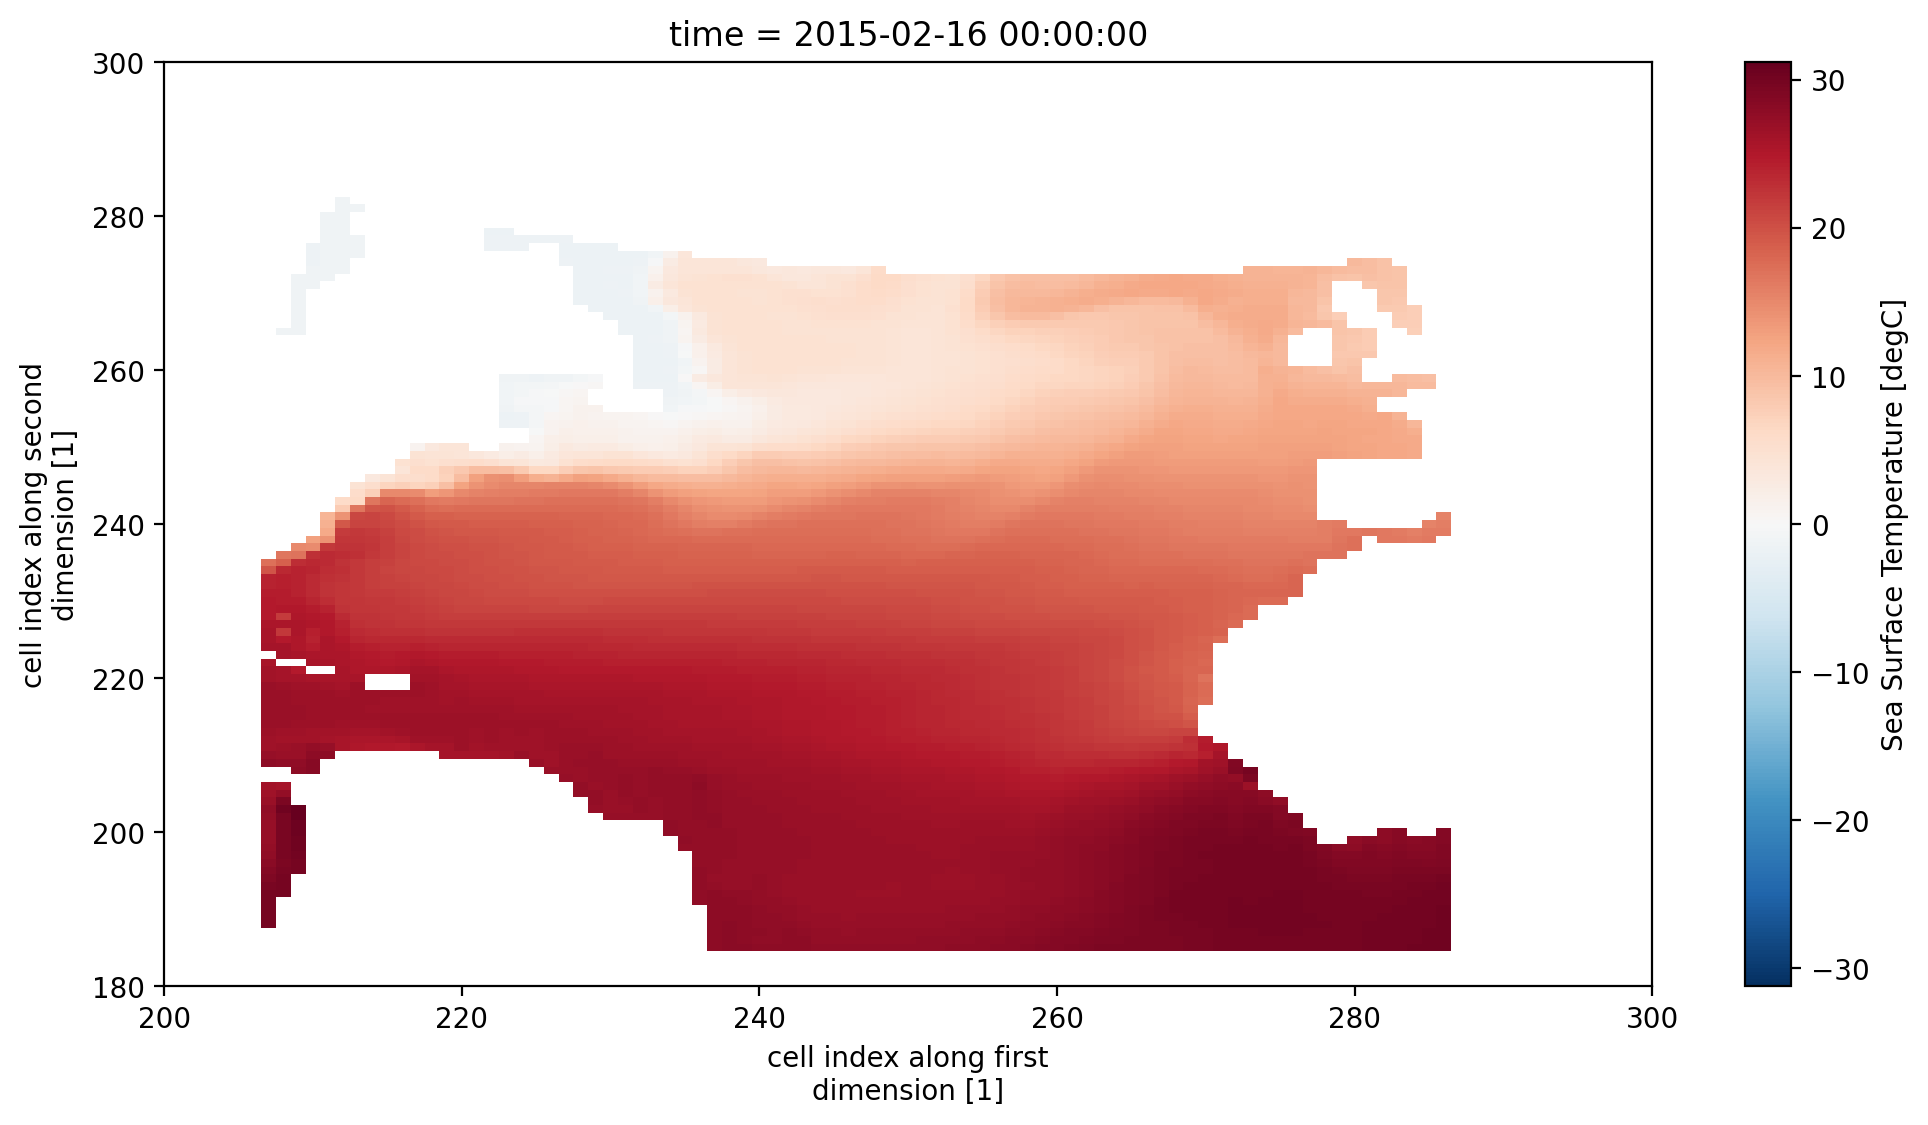

In [ ]:
ds1.tos.sel(time=ds['time'][1]).squeeze().plot(xlim=(200, 300), ylim=(180,300))

In [ ]:
df_area = df.query("variable_id == 'areacello' & source_id == 'UKESM1-0-LL'")
ds_area = xr.open_zarr(gcs.get_mapper(df_area.zstore.values[0]), consolidated=True)
df_area_g = df.query("variable_id == 'areacello' & source_id == 'UKESM1-0-LL'")
ds_area_g = xr.open_zarr(gcs.get_mapper(df_area.zstore.values[0]), consolidated=True)
ds_area

<xarray.Dataset>
Dimensions:             (j: 330, i: 360, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 323 324 325 326 327 328 329
    latitude            (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
Dimensions without coordinates: vertices
Data variables:
    areacello           (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   39600.0
    branch_time_in_parent:  39600.0
    cmor_version:           3.4.0
    ...                     ...
    tracking_id:            hdl:21.14100/048bb3c9-4cba-4860-823b-d6aafc7b1f2e
    variable_id:            areacello
    variant_label:          r1i1p1f2
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/048bb3c9-4cba-4860-823b-d6aafc7b1f2e
    version_id:             v20190705

In [ ]:
lon=ds['longitude']
lon = lon.compute()
lat=ds['latitude']
lat=lat.compute()
lon_g=ds_g['longitude']
lon_g = lon_g.compute()
lat_g=ds_g['latitude']
lat_g=lat_g.compute()
ds_area =ds_area.where(lon>=-80,drop=True)
ds_area =ds_area.where(lat<=60,drop=True)
ds_area =ds_area.where(lat>=0,drop=True)
ds_area =ds_area.where(lon<=0,drop=True)

In [ ]:
total_area = ds_area.areacello.sum(dim=['j', 'i'])
tos_timeseries = (ds.tos * ds_area.areacello).sum(dim=['j', 'i']) / total_area
total_area_g = ds_area_g.areacello.sum(dim=['j', 'i'])
tos_timeseries_g = (ds_g.tos * ds_area_g.areacello).sum(dim=['j', 'i']) / total_area_g
tos_timeseries

<xarray.DataArray (time: 1032)>
dask.array<truediv, shape=(1032,), dtype=float32, chunksize=(237,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2015-01-16 00:00:00 ... 2100-12-16 00:00:00

In [ ]:
total_area.compute()
total_area_g.compute()

<xarray.DataArray 'areacello' ()>
array(3.6312056e+14, dtype=float32)

Text(0.5, 1.0, 'Local Mean Surface Air Temperature')

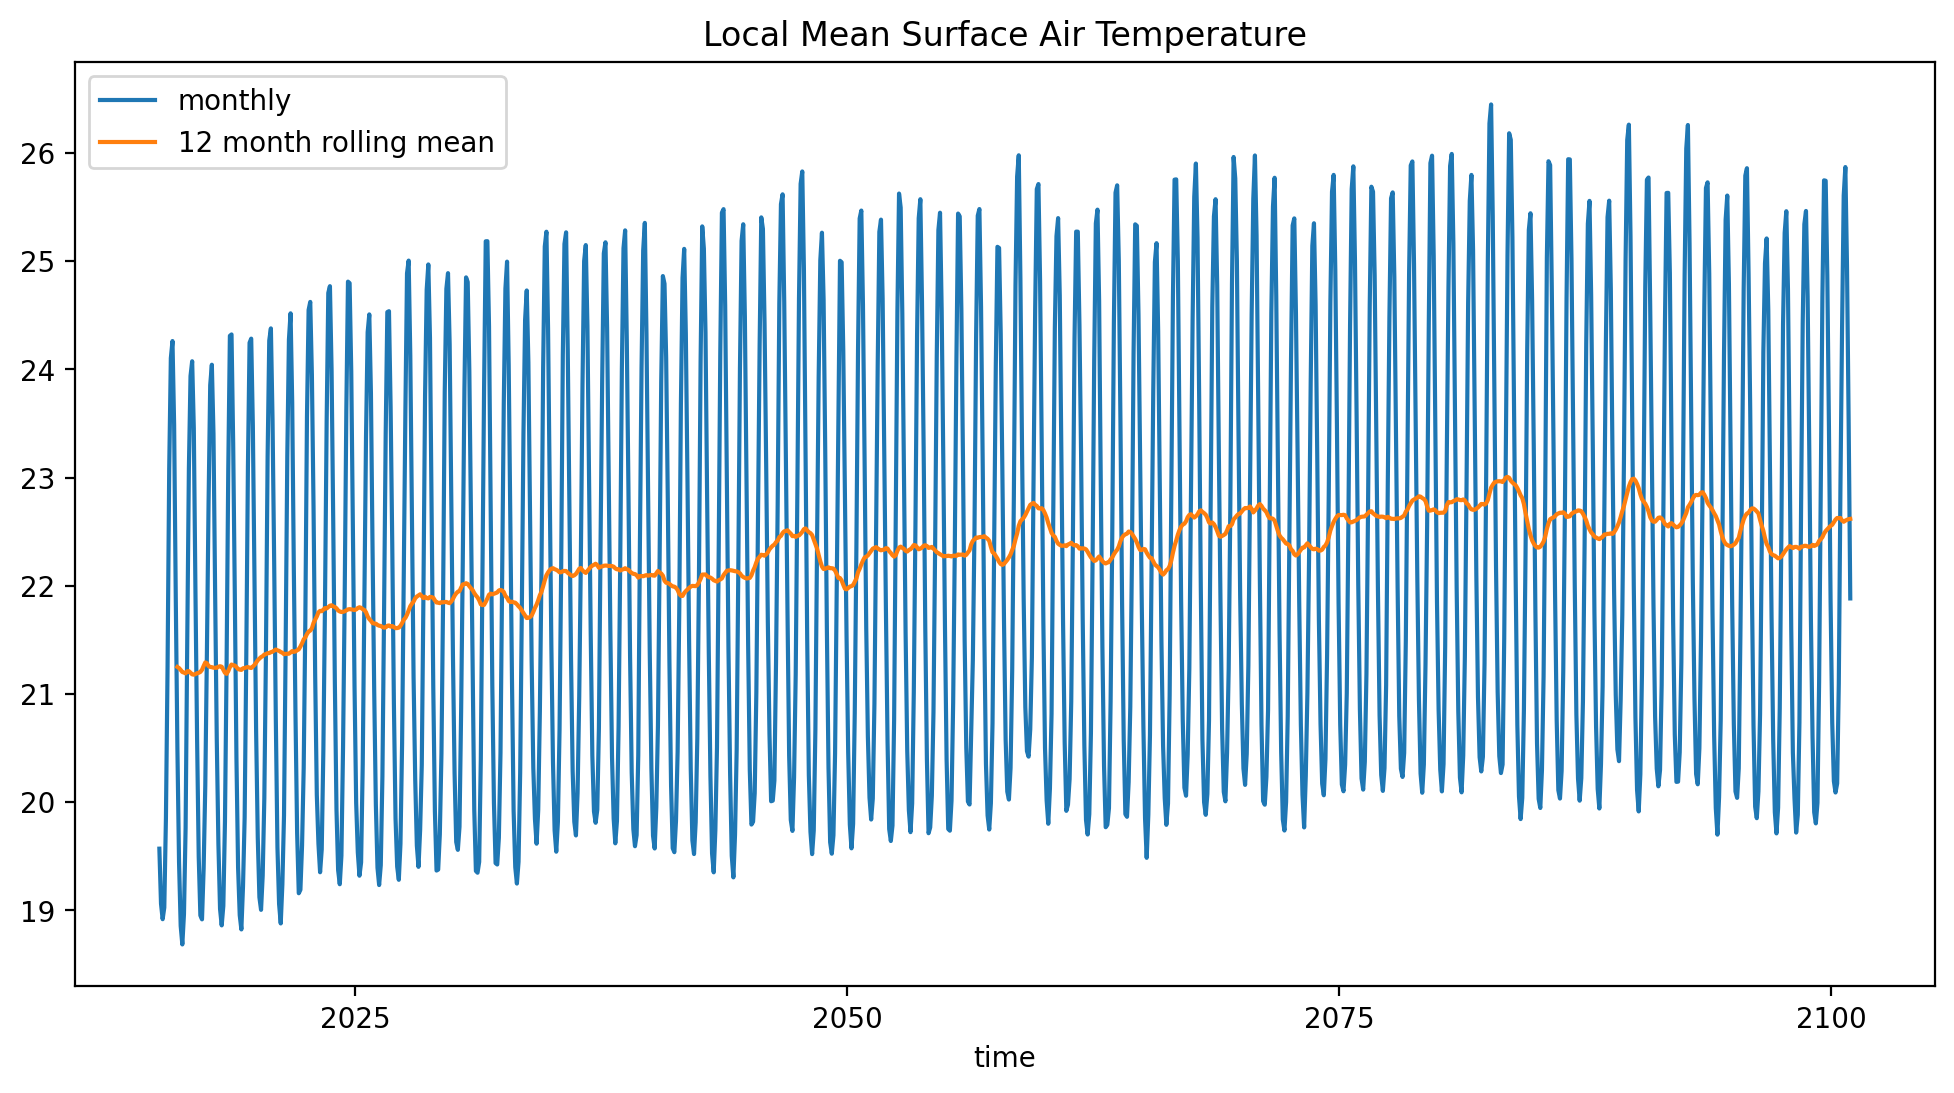

In [ ]:
tos_timeseries.plot(label='monthly')
tos_timeseries.rolling(time=12).mean().plot(label='12 month rolling mean')
plt.legend()
plt.title('Local Mean Surface Air Temperature')

Text(0.5, 1.0, 'Global Mean Surface Air Temperature')

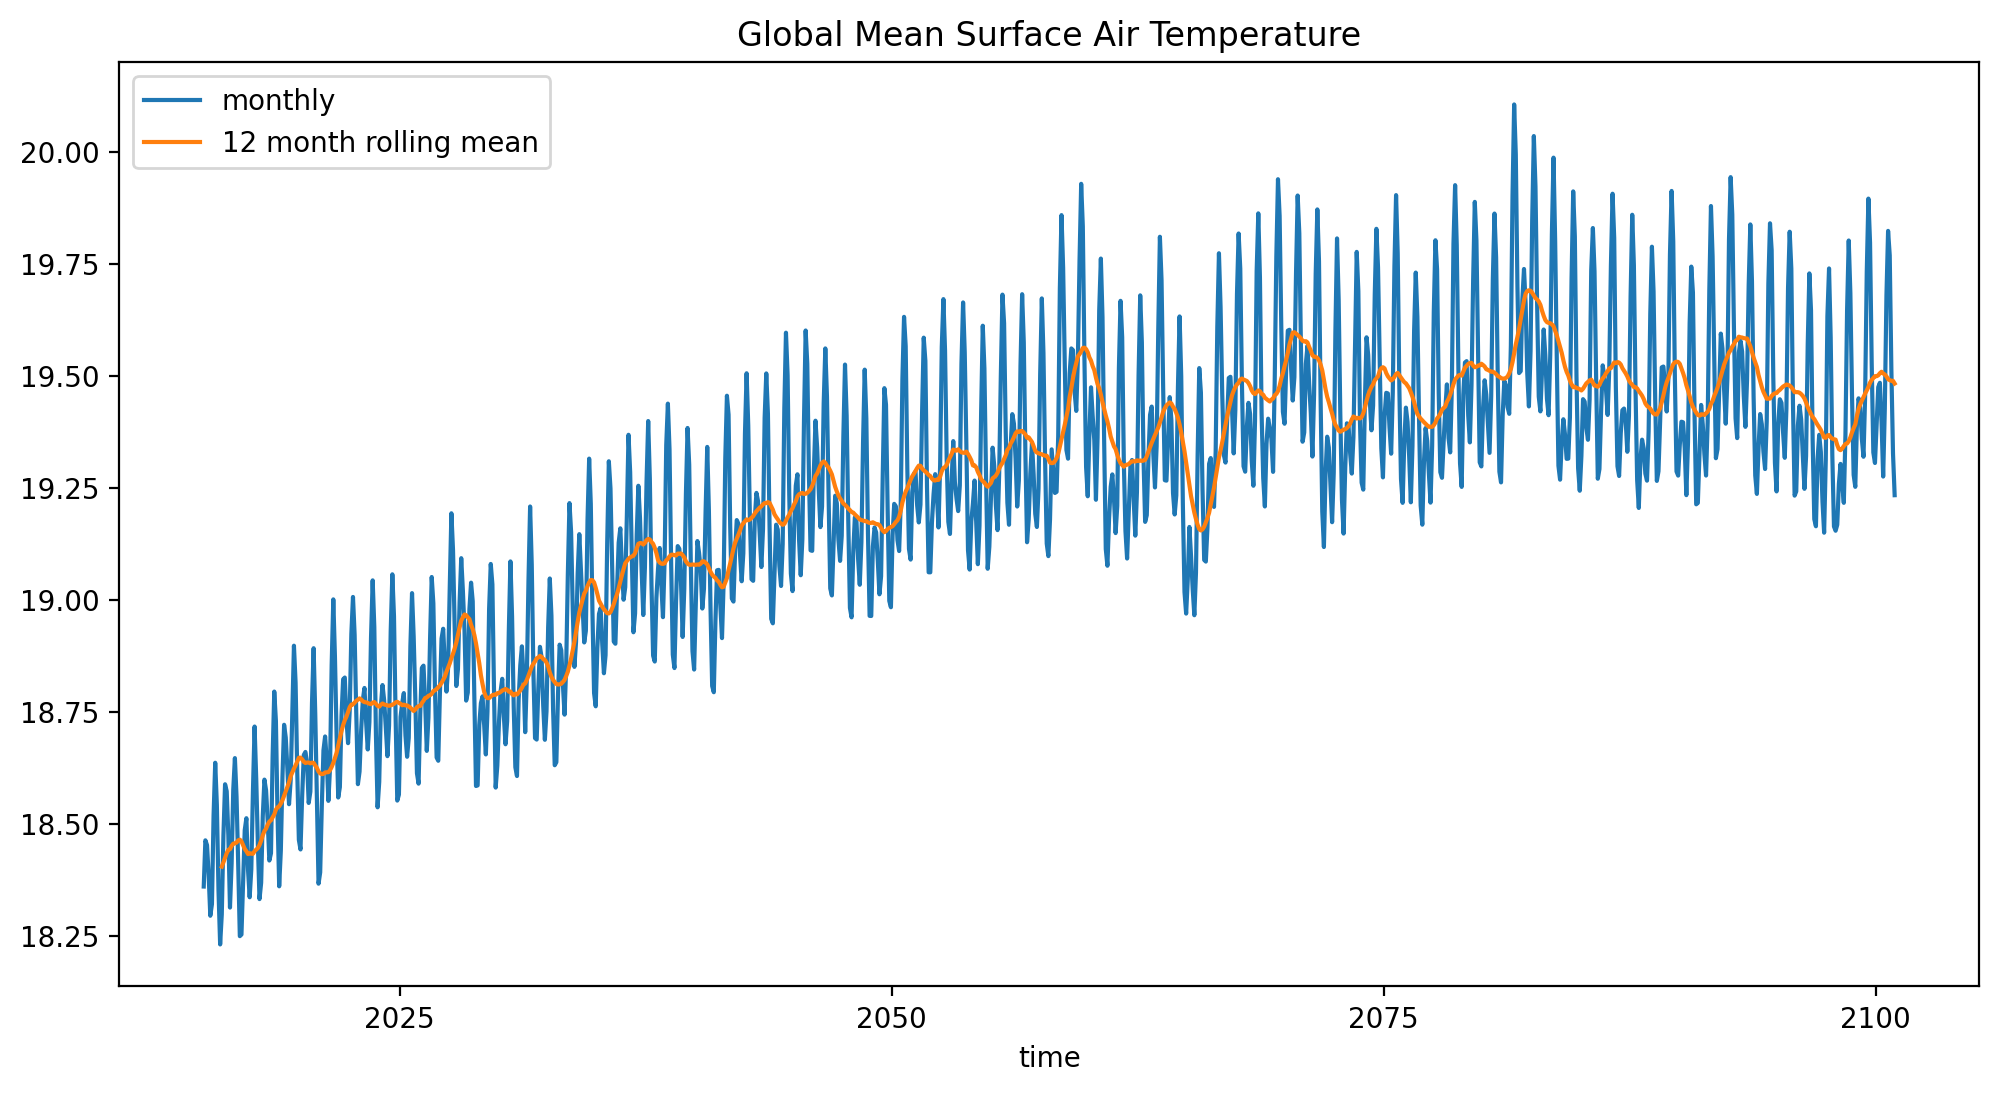

In [ ]:
tos_timeseries_g.plot(label='monthly')
tos_timeseries_g.rolling(time=12).mean().plot(label='12 month rolling mean')
plt.legend()
plt.title('Global Mean Surface Air Temperature')

In [ ]:
sst_clim = tos_timeseries.groupby('time.month').mean(dim='time')
sst_clim_g = tos_timeseries_g.groupby('time.month').mean(dim='time')

In [ ]:
ssta=tos_timeseries.groupby('time.month') - sst_clim
ssta_g=tos_timeseries_g.groupby('time.month') - sst_clim_g

/usr/local/lib/python3.10/dist-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]
/usr/local/lib/python3.10/dist-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 86 times more chunks
  return self.array[key]


In [ ]:
ssta

<xarray.DataArray (time: 1032)>
dask.array<sub, shape=(1032,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

<ipython-input-32-eb8bc59ecd26>:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ssta.drop('month').plot()


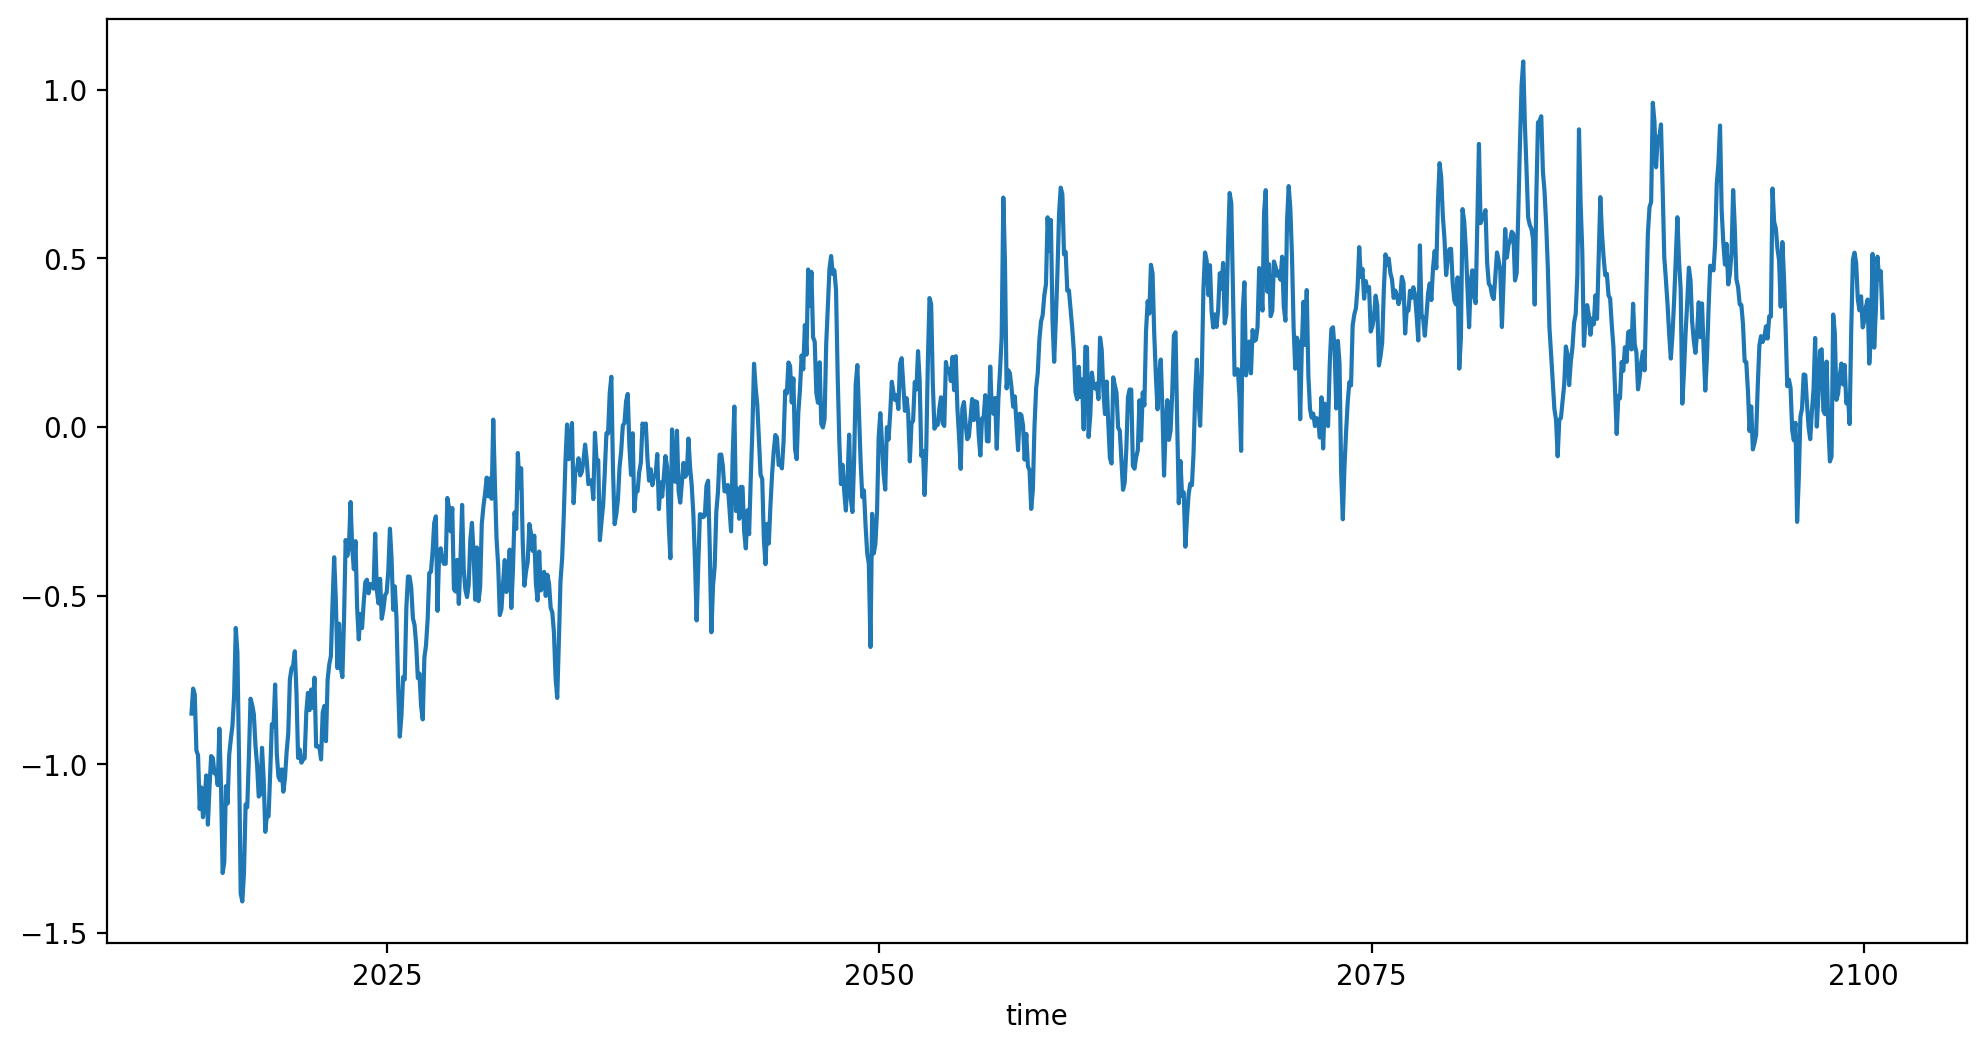

In [ ]:
ssta.drop('month').plot()

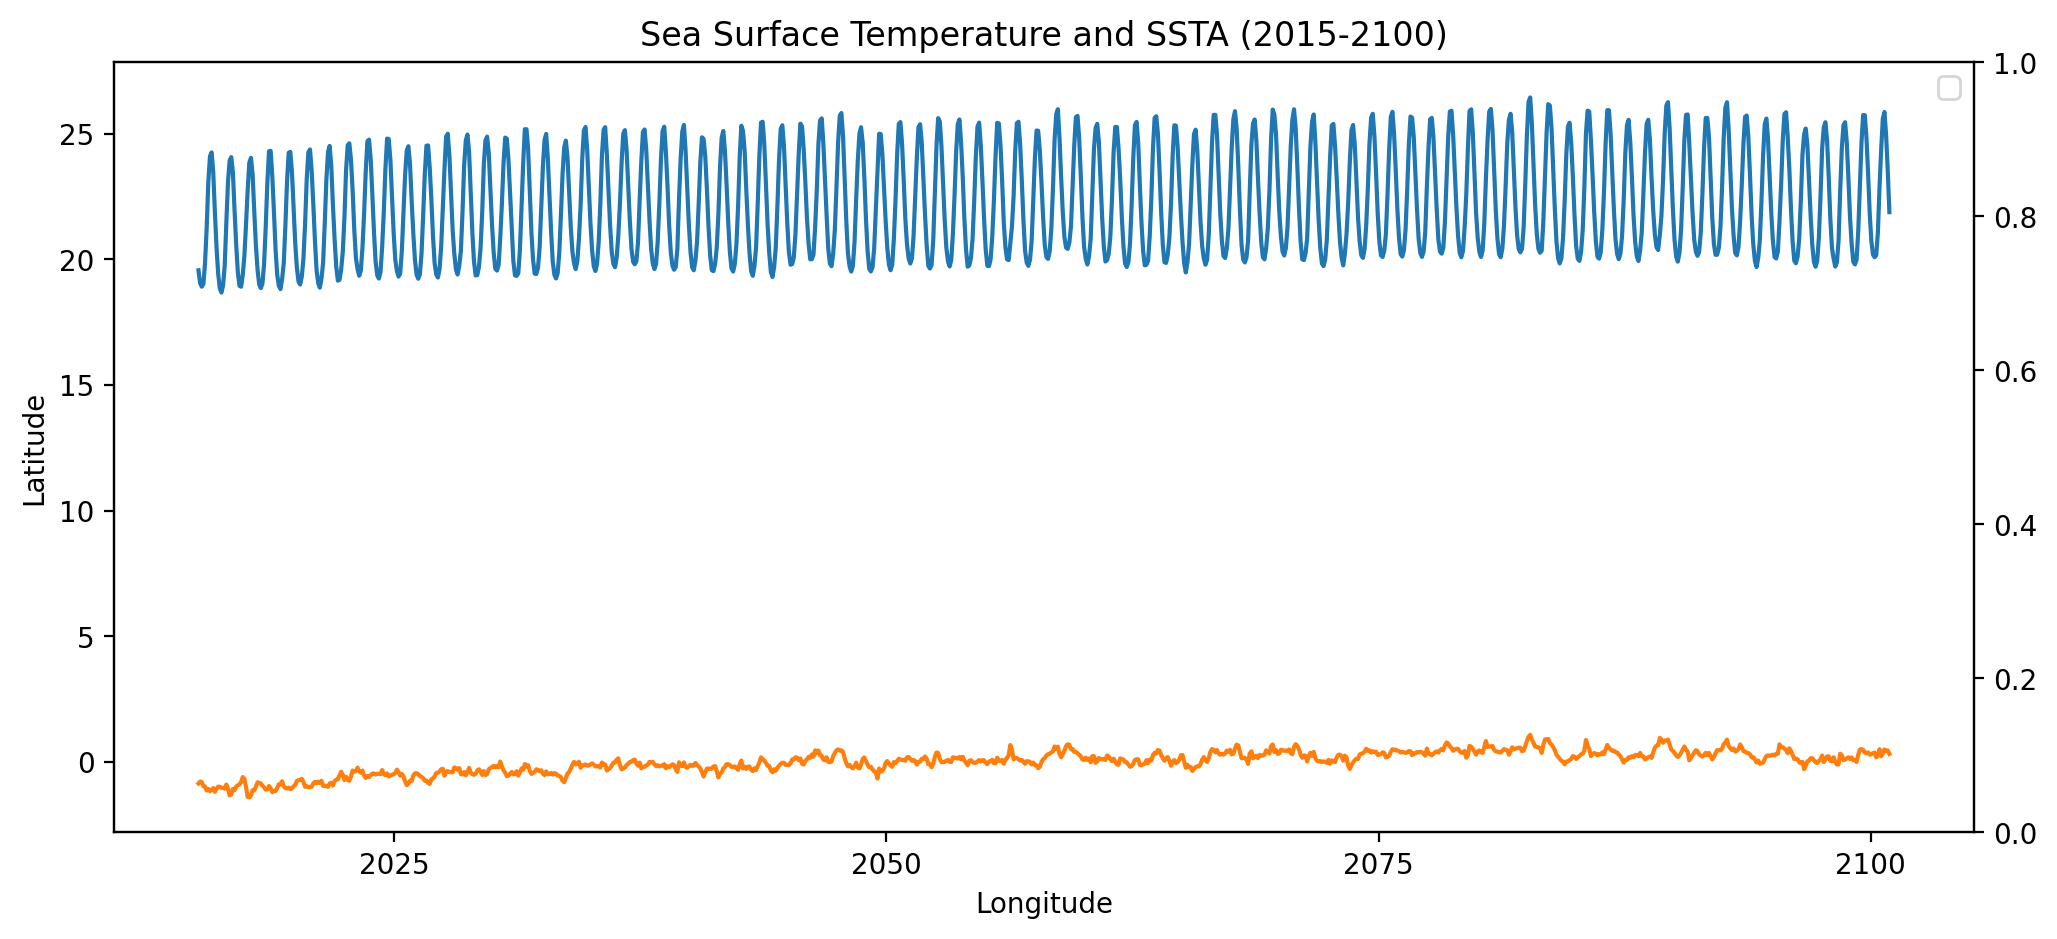

In [ ]:
# Plot the original sea surface temperature and SSTA
plt.figure(figsize=(12, 5))
tos_timeseries.sel(time=slice("2015-01-16", "2100-12-16")).plot(label='Original SST')
ssta.sel(time=slice("2015-01-16", "2100-12-16")).plot(label='SSTA')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Sea Surface Temperature and SSTA (2015-2100)')
plt.twinx()
plt.legend()
plt.show()

<ipython-input-34-94d1f832b992>:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ssta_g.drop('month').plot()


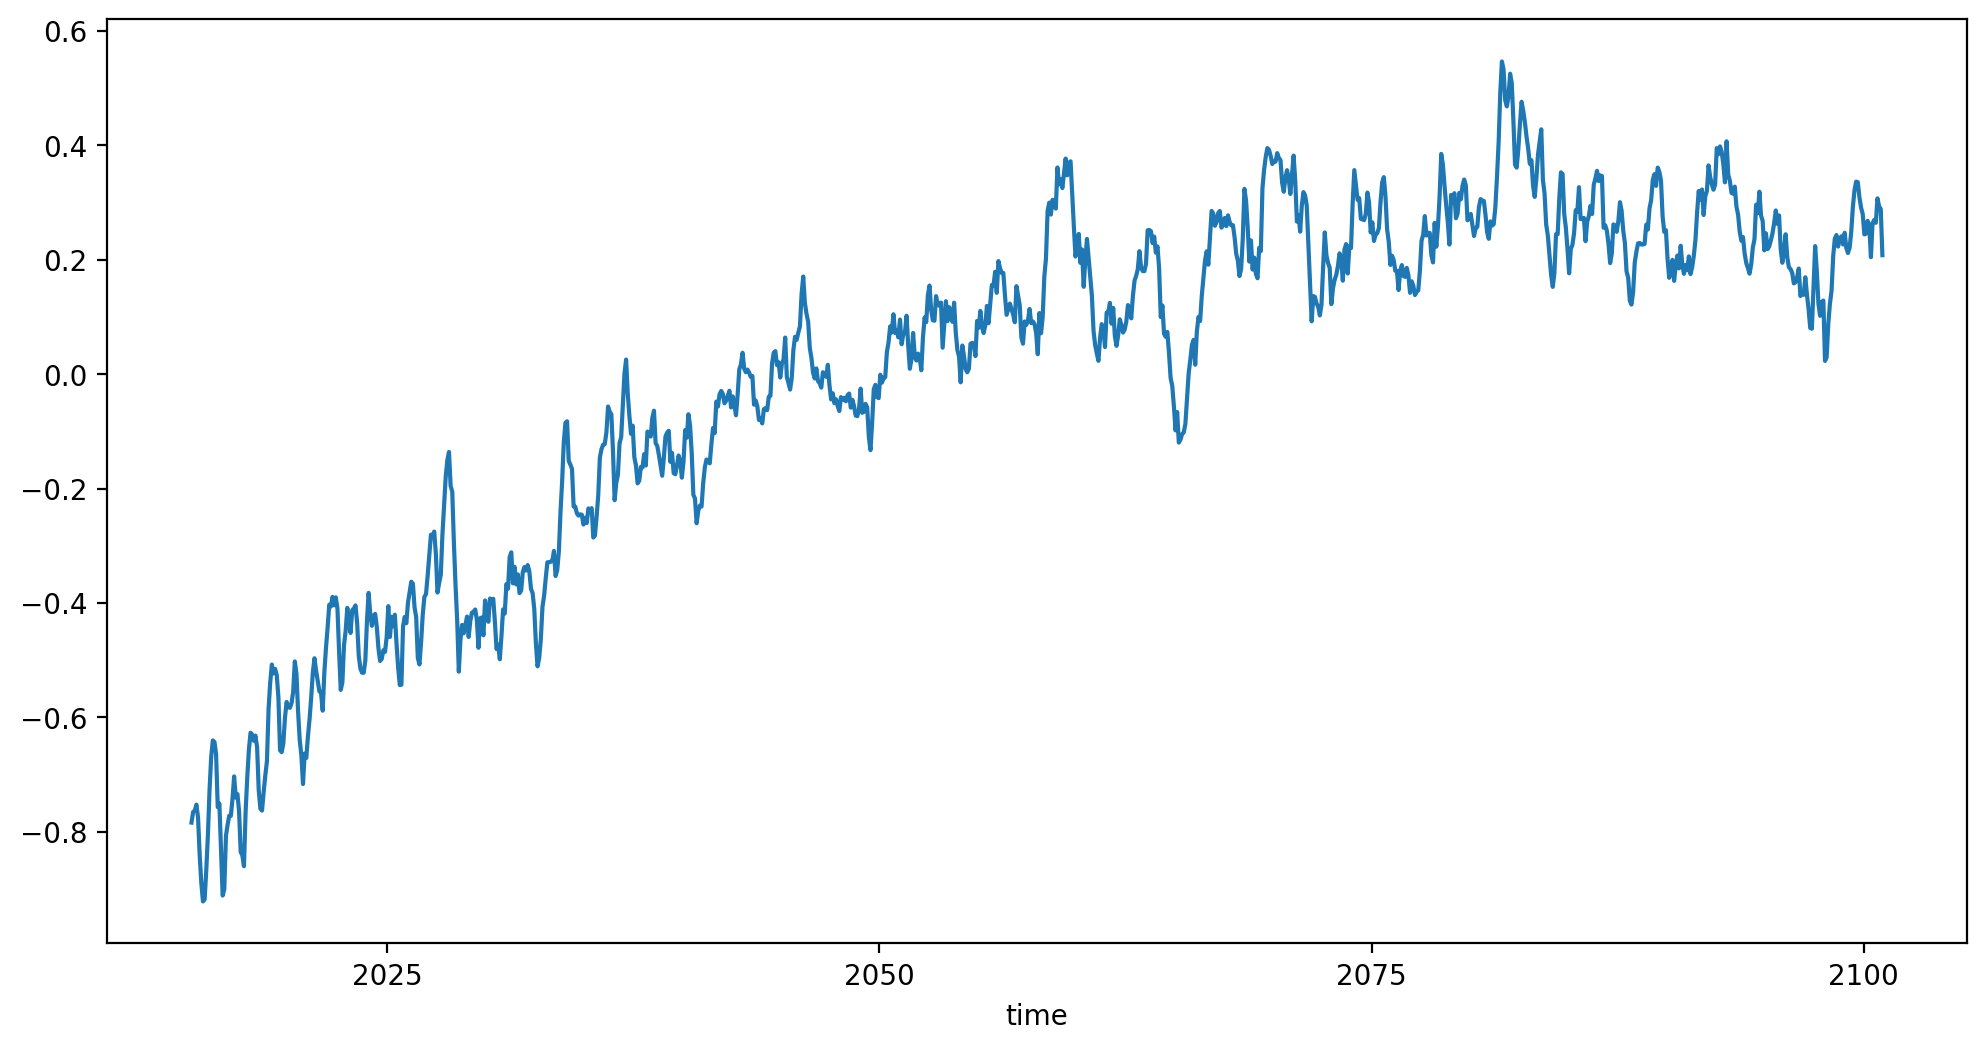

In [ ]:
ssta_g.drop('month').plot()

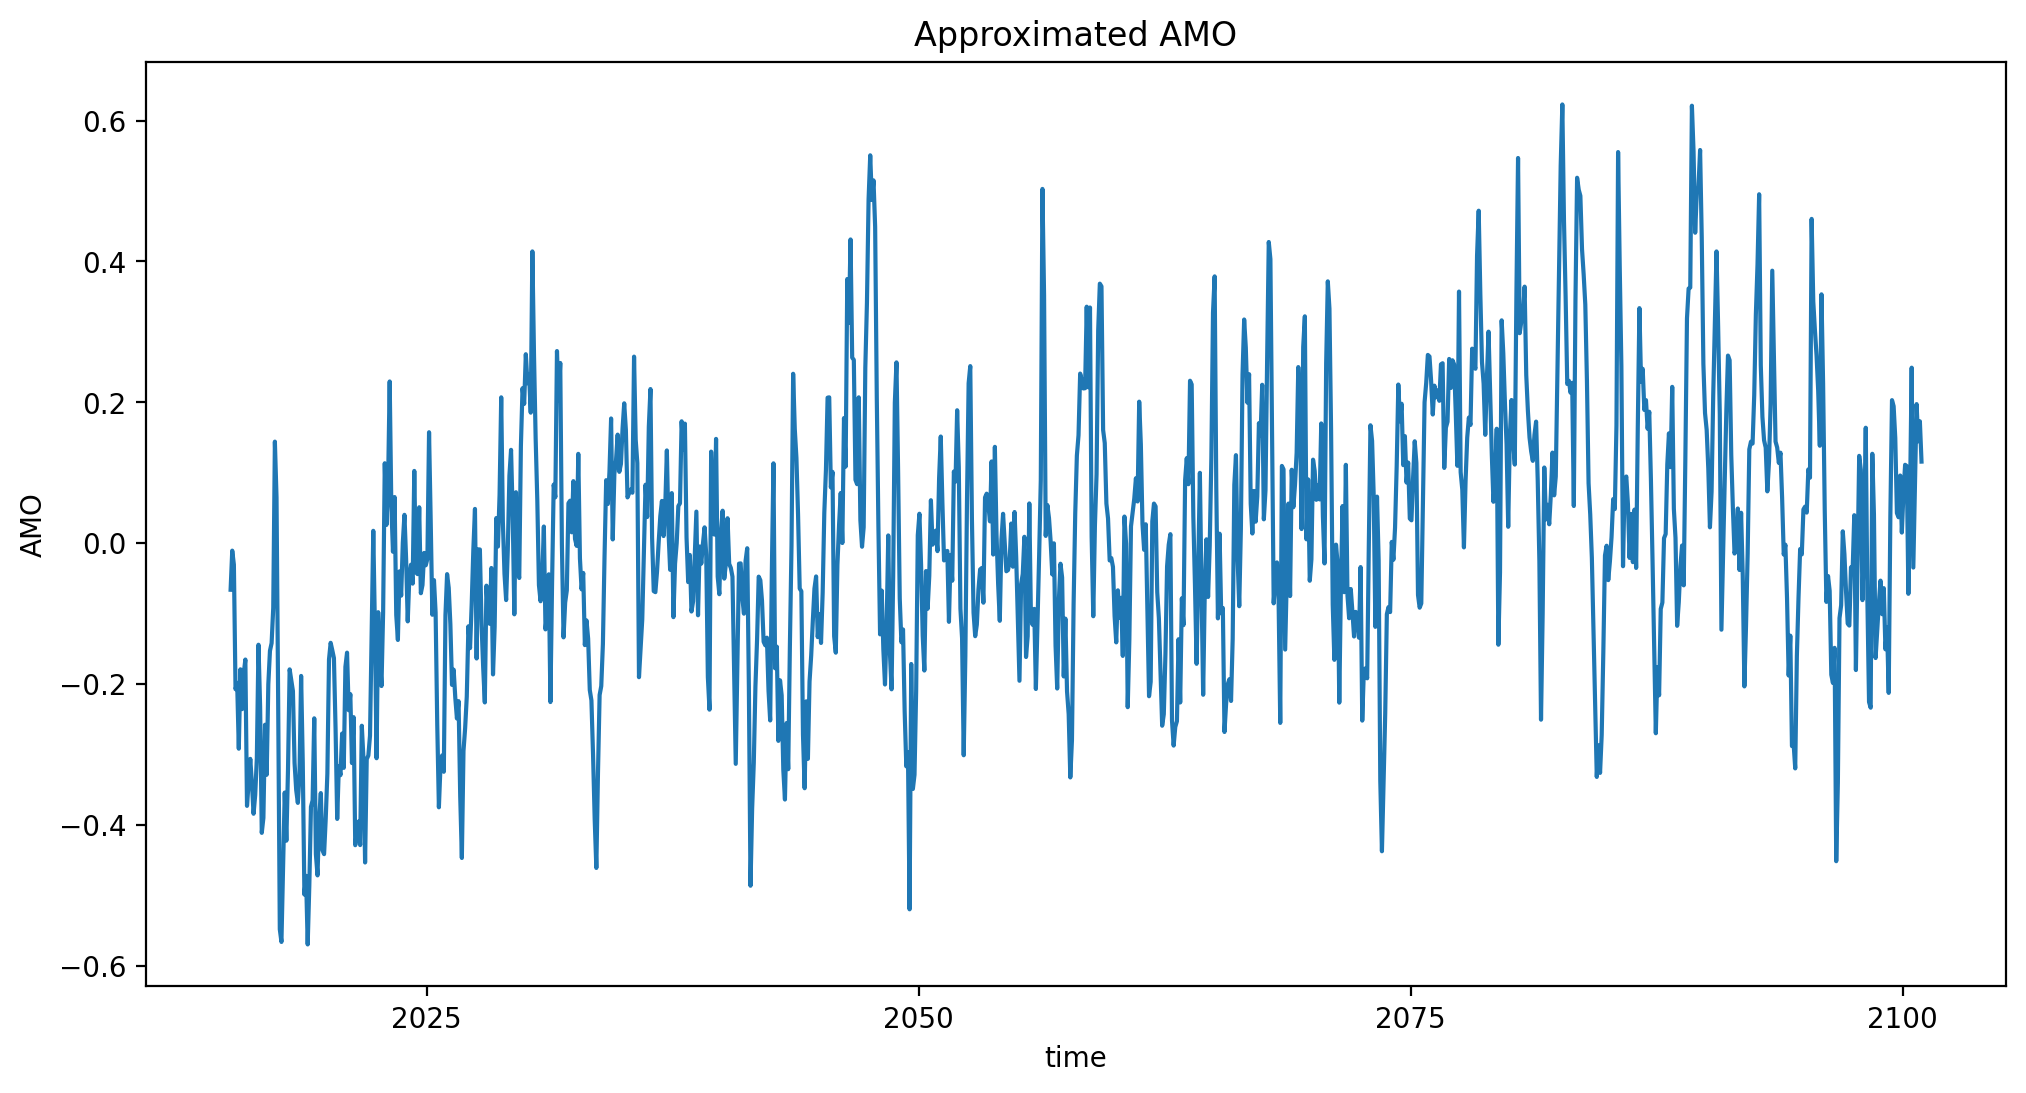

In [ ]:
amo=ssta.sel(time=slice("2015-01-16", "2100-12-16"))-ssta_g.sel(time=slice("2015-01-16", "2100-12-16"))
amo.plot(label='ssta- ssta_g')
plt.title('Approximated AMO')
plt.ylabel('AMO')
plt.show()

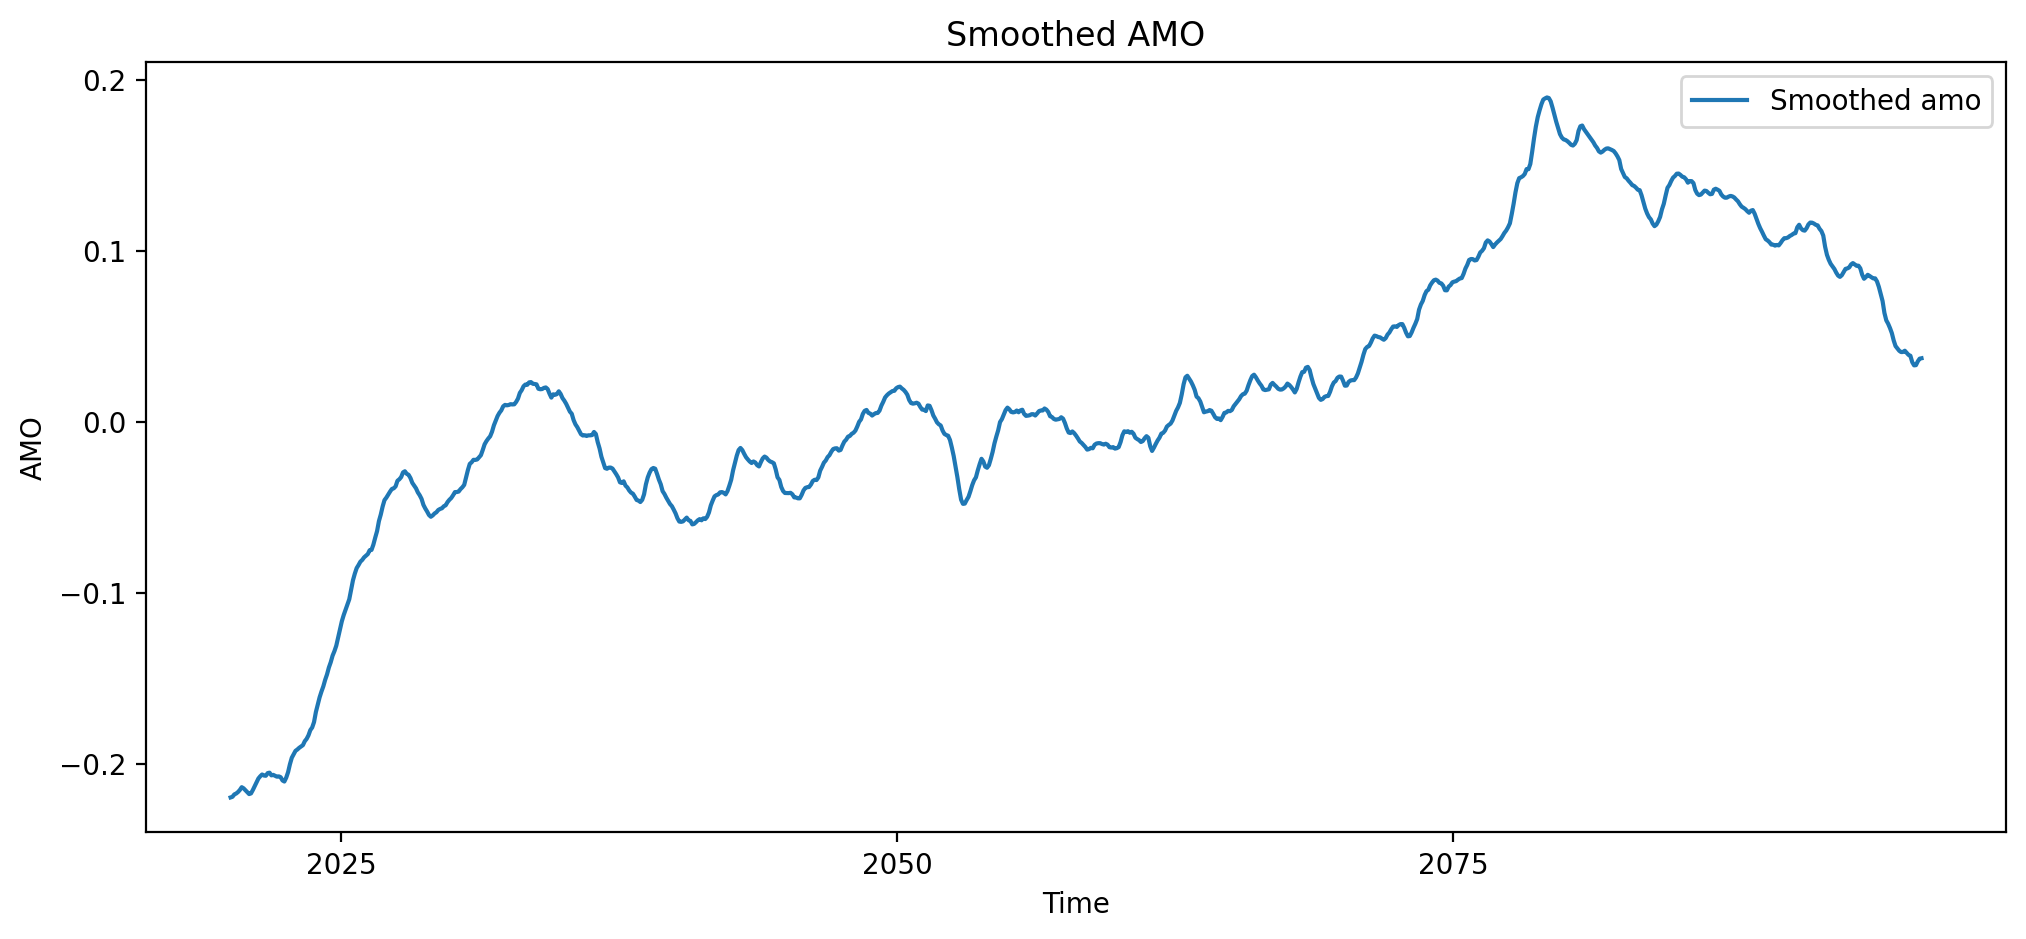

In [ ]:
import matplotlib.pyplot as plt

# Calculate the 10-year rolling mean (low-pass filter) for tosga
amo_smoothed = amo.rolling(time=120, center=True).mean()

plt.figure(figsize=(12, 5))

# Plot the smoothed tosga variable
amo_smoothed.sel(time=slice("2015-01-16", "2100-12-16")).plot(label='Smoothed amo')

# Add appropriate labels for the x and y axes
plt.xlabel('Time')
plt.ylabel('AMO')

# Add a title to the graph
plt.title('Smoothed AMO')

# Display the legend
plt.legend()

# Show the plot
plt.show()


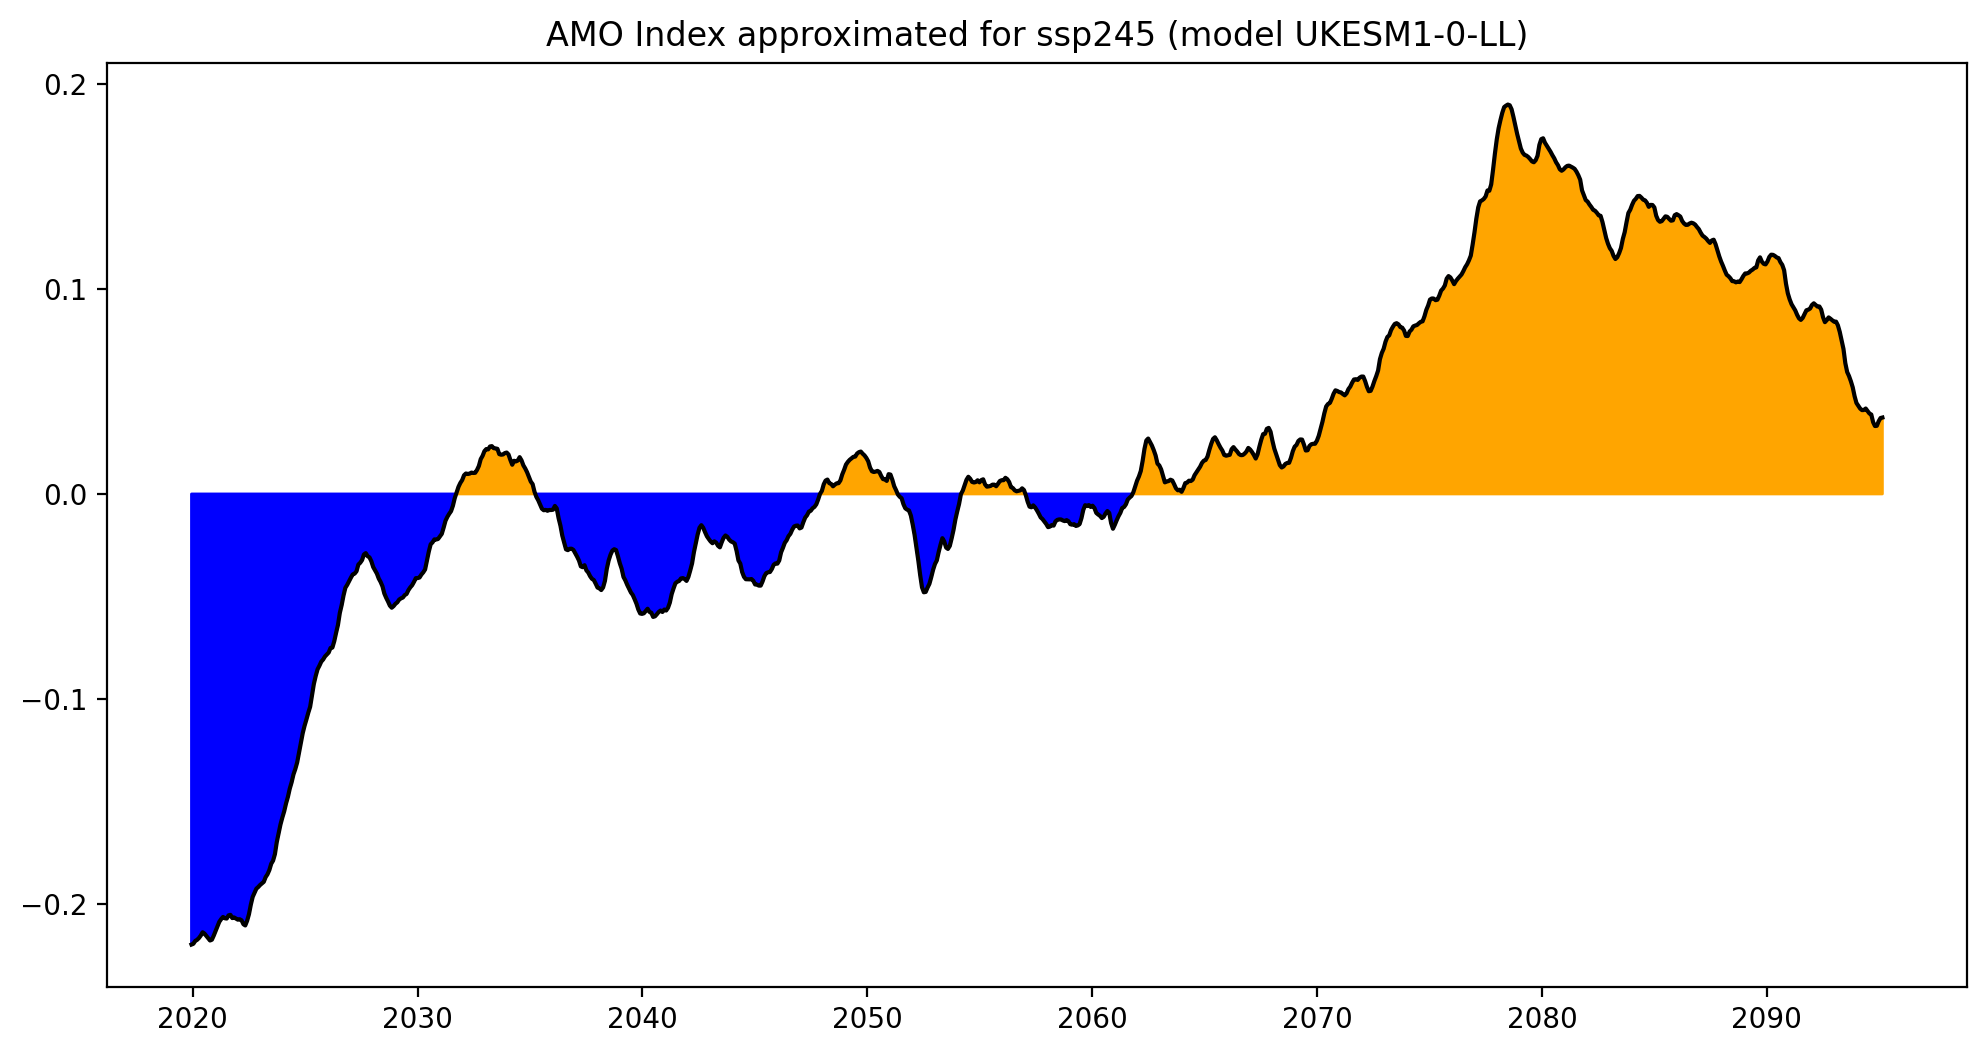

In [ ]:
# Program to calculate moving average
window_size = 5
moving_averages=np.array(amo_smoothed.sel(time=slice("2015-01-16", "2100-12-16")))
yrs=np.linspace(2015,2100,len(moving_averages))
plt.plot(yrs,moving_averages,color='black')
plt.title("AMO Index approximated for ssp245 (model UKESM1-0-LL)")
plt.fill_between(
        x=yrs ,
        y1= moving_averages,
        where= (0 < np.array(moving_averages)),
        color= "orange")
plt.fill_between(
        x= yrs,
        y1= moving_averages,
        where= (0 > np.array(moving_averages)),
        color= "blue")

#Second Step:

In [ ]:
# # We detrend the spatial averaged timeseries
# from sklearn.linear_model import LinearRegression
# X1= range(final_yr-start_yr)
# alpha1 = LinearRegression().fit(np.reshape(X1,(-1, 1)), sst_clim)

In [ ]:
# Linear regression (ssta to ssta_g) -> fonctionne √
ssta_transposed = ssta.transpose('time')
ds_regression = xr.Dataset({'ssta': (('time'), ssta_transposed.values)},
                 coords={'ssta_g': ('ssta_g',np.ravel(ssta_g.values))})
ssta_coeffs = ds_regression.polyfit('time', 1)

print(ssta_coeffs)

<xarray.Dataset>
Dimensions:                    (degree: 2)
Coordinates:
  * degree                     (degree) int64 1 0
Data variables:
    ssta_polyfit_coefficients  (degree) float64 0.001207 -0.6222


Text(0.5, 1.0, 'Linear Regression of SSTA over time')

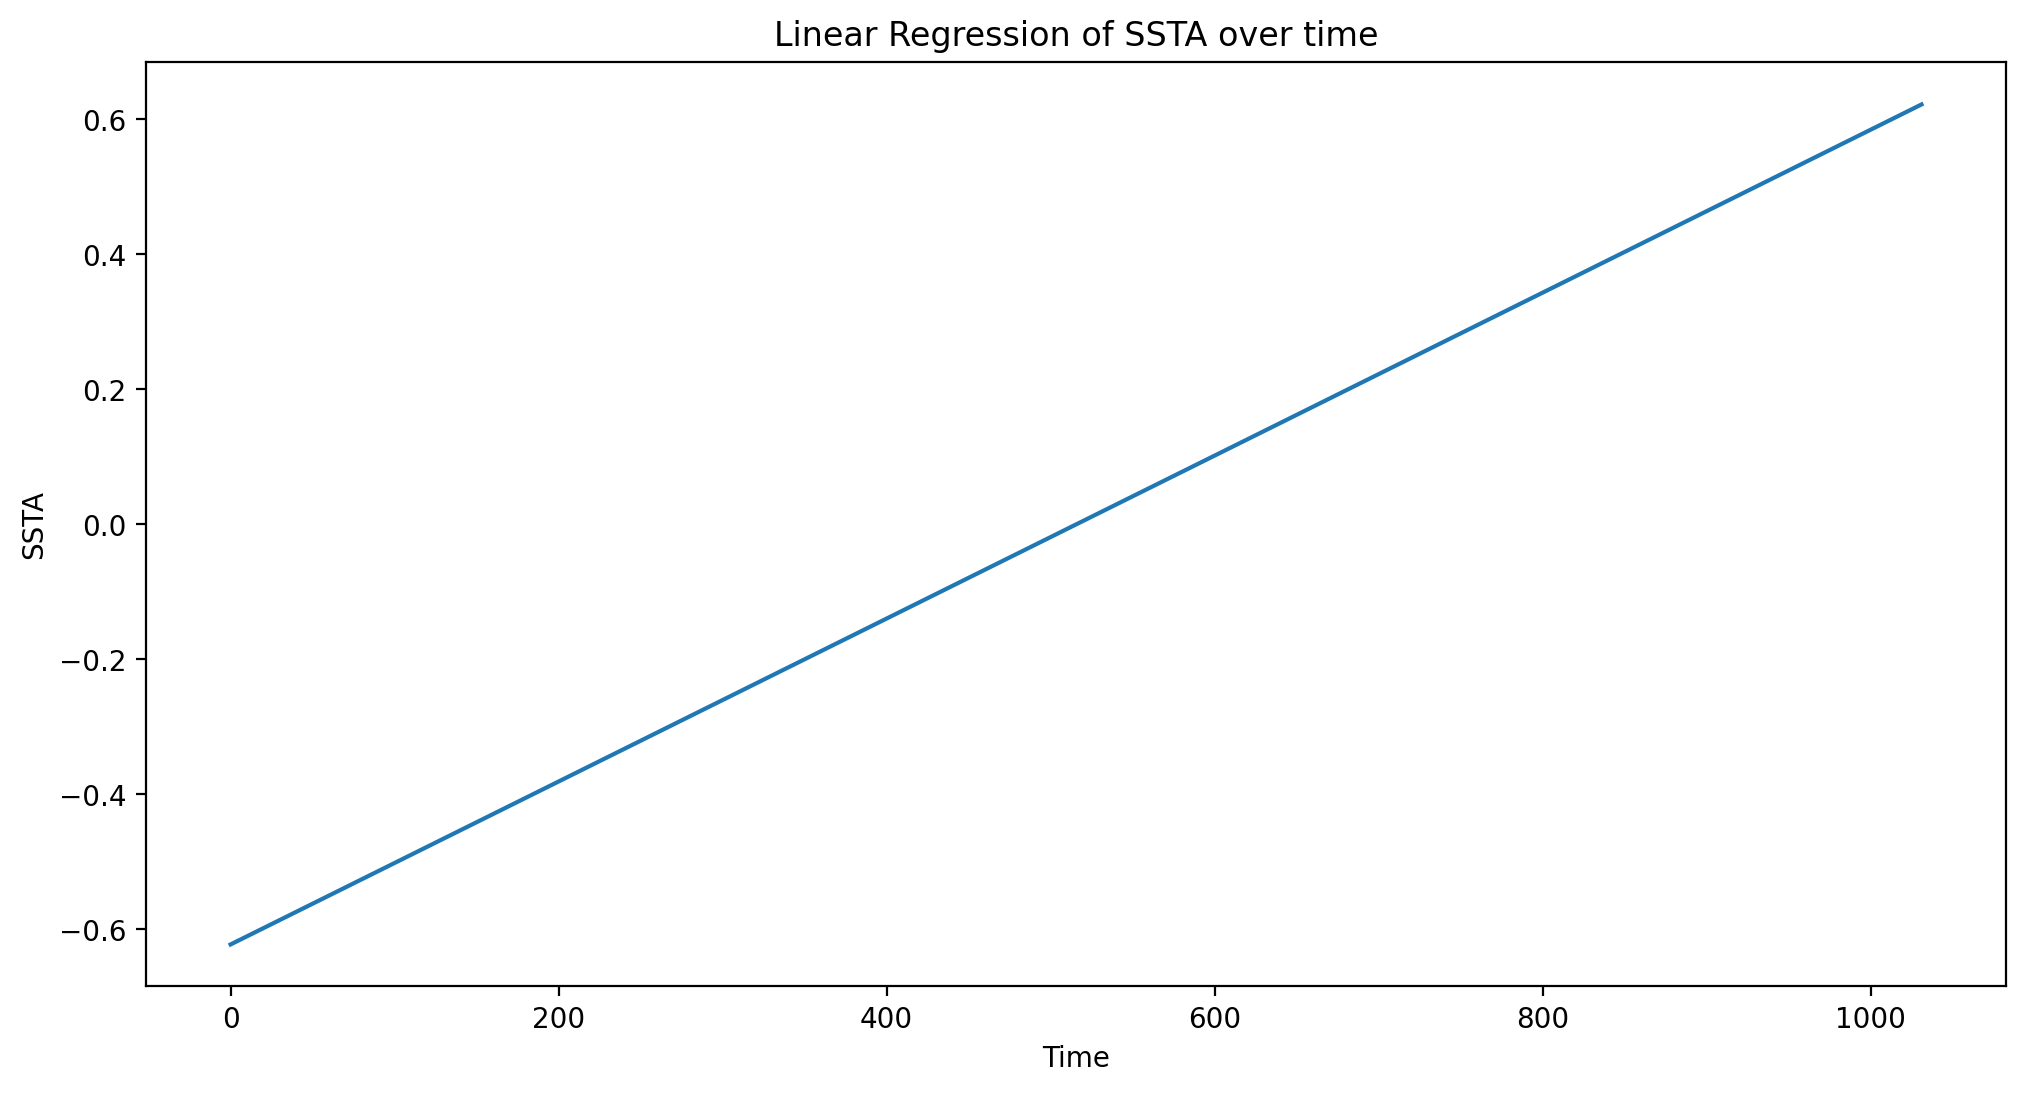

In [ ]:
# Extract the coefficients
coeffs =ssta_coeffs['ssta_polyfit_coefficients']
# Generate a fitted curve using polyval
fit_data = np.polyval(coeffs.values, ds_regression['time'].values)
# Plotting the fitted curve
plt.plot(ds_regression['time'], fit_data, label = 'Fitted Curve')
plt.xlabel('Time')
plt.ylabel('SSTA')
plt.title('Linear Regression of SSTA over time')

In [ ]:
# Fitted data -> √
# ssta_coeffs_map = ssta_coeffs.sel(degree=1)
# ssta_coeffs_map = ssta_coeffs_map.assign_coords(degree=[1])
# fit_data = xr.polyval(ds_regression['ssta_g'], ssta_coeffs_map)
# print(fit_data)

In [ ]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

# look for simulations that correspond to our chosen criteria and contain SST data

df_sst = df.query("source_id=='UKESM1-0-LL'& experiment_id=='ssp126' & table_id == 'Omon' & variable_id == 'tos' & member_id=='r1i1p1f2'	")

# look for simulations that correspond to our chosen criteria and contain global mean SST data
df_sst_g = df.query("source_id=='UKESM1-0-LL'& experiment_id=='ssp126' & table_id == 'Omon' & variable_id == 'tosga' & member_id=='r1i1p1f2'	")

# get the list of members for which both variables are available
members = np.union1d(df_sst.member_id.values,df_sst_g.member_id.values)

# and take the first one in the list to use in this example
target_member = members[0]
df_sst = df_sst.loc[df_sst['member_id'] == target_member]
df_sst_g = df_sst_g.loc[df_sst_g['member_id'] == target_member]

# === now we retrieve these two variables
gcs = gcsfs.GCSFileSystem(token='anon')
# first retrieve SST
mapper = gcs.get_mapper(df_sst.zstore.values[0])
ds_sst = xr.open_zarr(mapper, consolidated=True)
# then global SST
mapper = gcs.get_mapper(df_sst_g.zstore.values[0])
ds_sst_g = xr.open_zarr(mapper, consolidated=True)

# and reduce the SST to the North Atlantic region:
lat = ds_sst.latitude.compute()
lon = ds_sst.longitude.compute()
ds_sst = ds_sst.where(((lat > 0) & (lat < 60) & (lon > -80) & (lon < 0)),drop=True)
ds_regression = xr.Dataset({'tos': (('tosga','j','i'),ds_sst.tos.values)},
                 coords={'tosga': ('tosga',np.ravel(ds_sst_g.tosga.values))})
# this contains the North Atlantic SST data as a data variable, and the global
# SST data as a dimension variable. Now we can perform the linear regression:
sst_coeffs = ds_regression.polyfit('tosga',1)
# -- we have now completed the first part of step 2.

# next we want to predict the North Atlantic SST at each point as a function
# of the global SST using these coefficients. We can do this using xr.polyval:
tfit = xr.polyval(ds_regression.tosga,sst_coeffs)
# and then we rename the dimensions of these outputs to be consistent
# with the original data set:
tfit = tfit.rename_dims({'tosga': 'time'})
# note: the above step produces a warning. You can ignore it.

# replace the global time series data that we used for the regression by
# the original time data
tfit['tosga'] = ('time',ds['time'].values)
# and also rename the variables
tfit = tfit.rename({'tos_polyfit_coefficients': 'tos', 'tosga': 'time'})
# -- we have now completed the second part of step 2

# Finally, we can subtract this estimate from the original data. The dimensions
# and variable names are all the same, so xarray should do this for us with no
# problems:
#ds_sst['tos'] = ds_sst['tos'] - tfit['tos']

<ipython-input-42-8a668df9ce2e>:50: UserWarning: rename 'tosga' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  tfit = tfit.rename({'tos_polyfit_coefficients': 'tos', 'tosga': 'time'})


In [ ]:
ds_sst = ds_sst.assign({'tos2': (('time','j','i'),ds_sst['tos'].data-tfit['tos'].data)})
ds_sst

<xarray.Dataset>
Dimensions:             (time: 1032, j: 97, i: 80, vertices: 4, bnds: 2)
Coordinates:
  * i                   (i) int32 207 208 209 210 211 ... 282 283 284 285 286
  * j                   (j) int32 186 187 188 189 190 ... 278 279 280 281 282
    latitude            (j, i) float32 0.3333 0.3333 0.3333 ... 63.76 63.59
    longitude           (j, i) float32 -79.5 -78.5 -77.5 ... 3.672 4.85 6.018
  * time                (time) object 2015-01-16 00:00:00 ... 2100-12-16 00:0...
    time_bnds           (time, bnds) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
Dimensions without coordinates: vertices, bnds
Data variables:
    tos                 (time, j, i) float32 dask.array<chunksize=(237, 97, 80), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float32 dask.array<chunksize=(97, 80, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float32 dask.array<chunksize=(97, 80, 4), meta=np.ndarray>
    tos2                (time, j, i) float64 dask.array<chunksize=(237, 97, 80), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   59400.0
    branch_time_in_parent:  59400.0
    cmor_version:           3.4.0
    ...                     ...
    tracking_id:            hdl:21.14100/b2921001-6081-42d2-92e5-1477a90a552c...
    variable_id:            tos
    variant_label:          r1i1p1f2
    status:                 2019-11-09;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/b2921001-6081-42d2-92e5-1477a90a552c...
    version_id:             v20190708

In [ ]:
tfit

<xarray.Dataset>
Dimensions:  (j: 97, i: 80, time: 1032)
Coordinates:
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 87 88 89 90 91 92 93 94 95 96
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 70 71 72 73 74 75 76 77 78 79
    time     (time) object 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
Data variables:
    tos      (time, j, i) float64 nan nan nan nan nan ... nan nan nan nan nan

In [ ]:
ds_sst

<xarray.Dataset>
Dimensions:             (time: 1032, j: 97, i: 80, vertices: 4, bnds: 2)
Coordinates:
  * i                   (i) int32 207 208 209 210 211 ... 282 283 284 285 286
  * j                   (j) int32 186 187 188 189 190 ... 278 279 280 281 282
    latitude            (j, i) float32 0.3333 0.3333 0.3333 ... 63.76 63.59
    longitude           (j, i) float32 -79.5 -78.5 -77.5 ... 3.672 4.85 6.018
  * time                (time) object 2015-01-16 00:00:00 ... 2100-12-16 00:0...
    time_bnds           (time, bnds) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
Dimensions without coordinates: vertices, bnds
Data variables:
    tos                 (time, j, i) float32 dask.array<chunksize=(237, 97, 80), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float32 dask.array<chunksize=(97, 80, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float32 dask.array<chunksize=(97, 80, 4), meta=np.ndarray>
    tos2                (time, j, i) float64 dask.array<chunksize=(237, 97, 80), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   59400.0
    branch_time_in_parent:  59400.0
    cmor_version:           3.4.0
    ...                     ...
    tracking_id:            hdl:21.14100/b2921001-6081-42d2-92e5-1477a90a552c...
    variable_id:            tos
    variant_label:          r1i1p1f2
    status:                 2019-11-09;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/b2921001-6081-42d2-92e5-1477a90a552c...
    version_id:             v20190708

In [ ]:
ds_regression = xr.Dataset({'tos': (('tosga','j','i'),ds_sst.tos2.values)},
                 coords={'tosga': ('tosga',amo.values)})
# this contains the North Atlantic SST data as a data variable, and the global
# SST data as a dimension variable. Now we can perform the linear regression:
sst_coeffs = ds_regression.polyfit('tosga',1)
# -- we have now completed the first part of step 2.

# next we want to predict the North Atlantic SST at each point as a function
# of the global SST using these coefficients. We can do this using xr.polyval:
tfit = xr.polyval(ds_regression.tosga,sst_coeffs)
# and then we rename the dimensions of these outputs to be consistent
# with the original data set:
tfit = tfit.rename_dims({'tosga': 'time'})
# note: the above step produces a warning. You can ignore it.

# replace the global time series data that we used for the regression by
# the original time data
tfit['tosga'] = ('time',ds['time'].values)
# and also rename the variables
tfit = tfit.rename({'tos_polyfit_coefficients': 'tos', 'tosga': 'time'})
# -- we have now completed the second part of step 2

# Finally, we can subtract this estimate from the original data. The dimensions
# and variable names are all the same, so xarray should do this for us with no
# problems:
ds_sst['tos'] = ds_sst['tos'] - tfit['tos']
# -- we have now completed the third part of step 3: we have removed the
# imprint of the global SST change from each point in the grid, and we are
# left with the SST anomaly.

# By modifying and repeating the regression example above, you can
# calculate the regression of the SST anomaly data on to your AMO index
# to obtain the AMO pattern

<ipython-input-46-171afa2e9035>:20: UserWarning: rename 'tosga' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  tfit = tfit.rename({'tos_polyfit_coefficients': 'tos', 'tosga': 'time'})


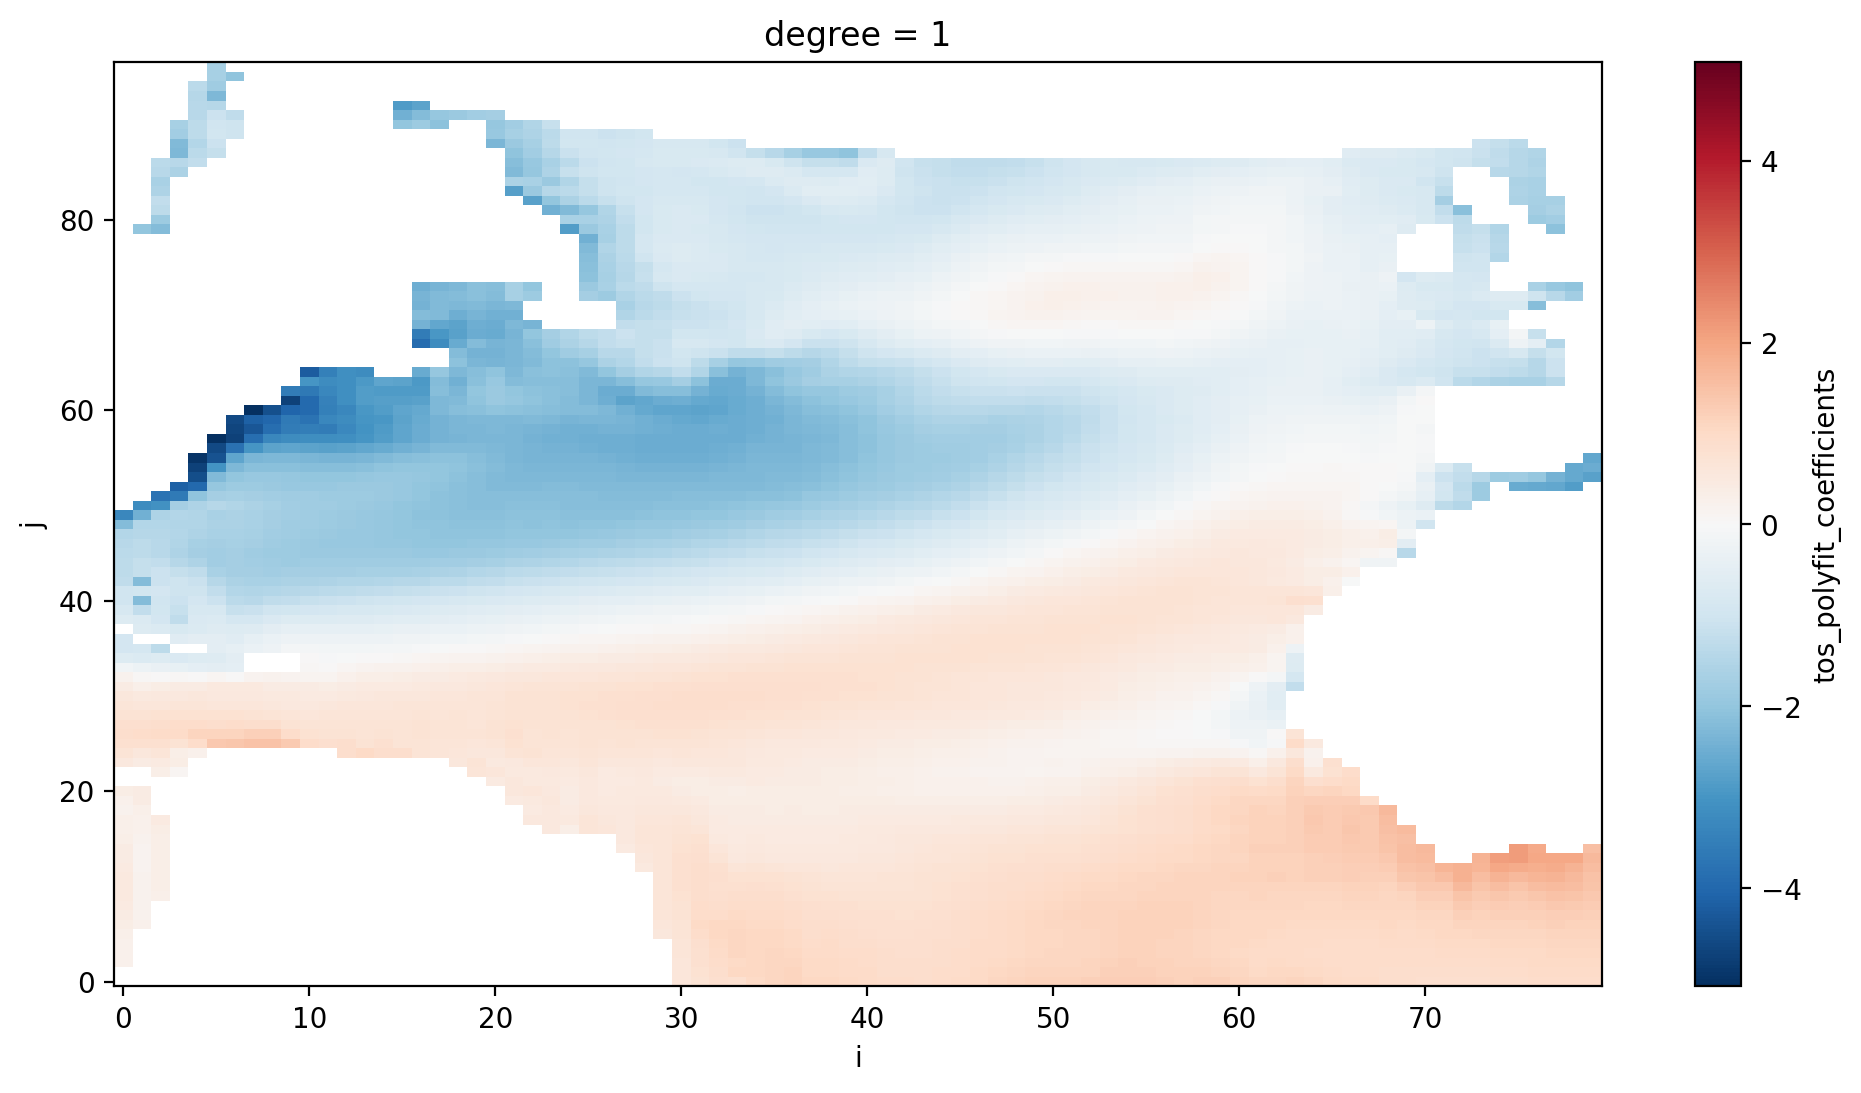

In [ ]:
sst_coeffs.sel(degree=1).tos_polyfit_coefficients.plot()

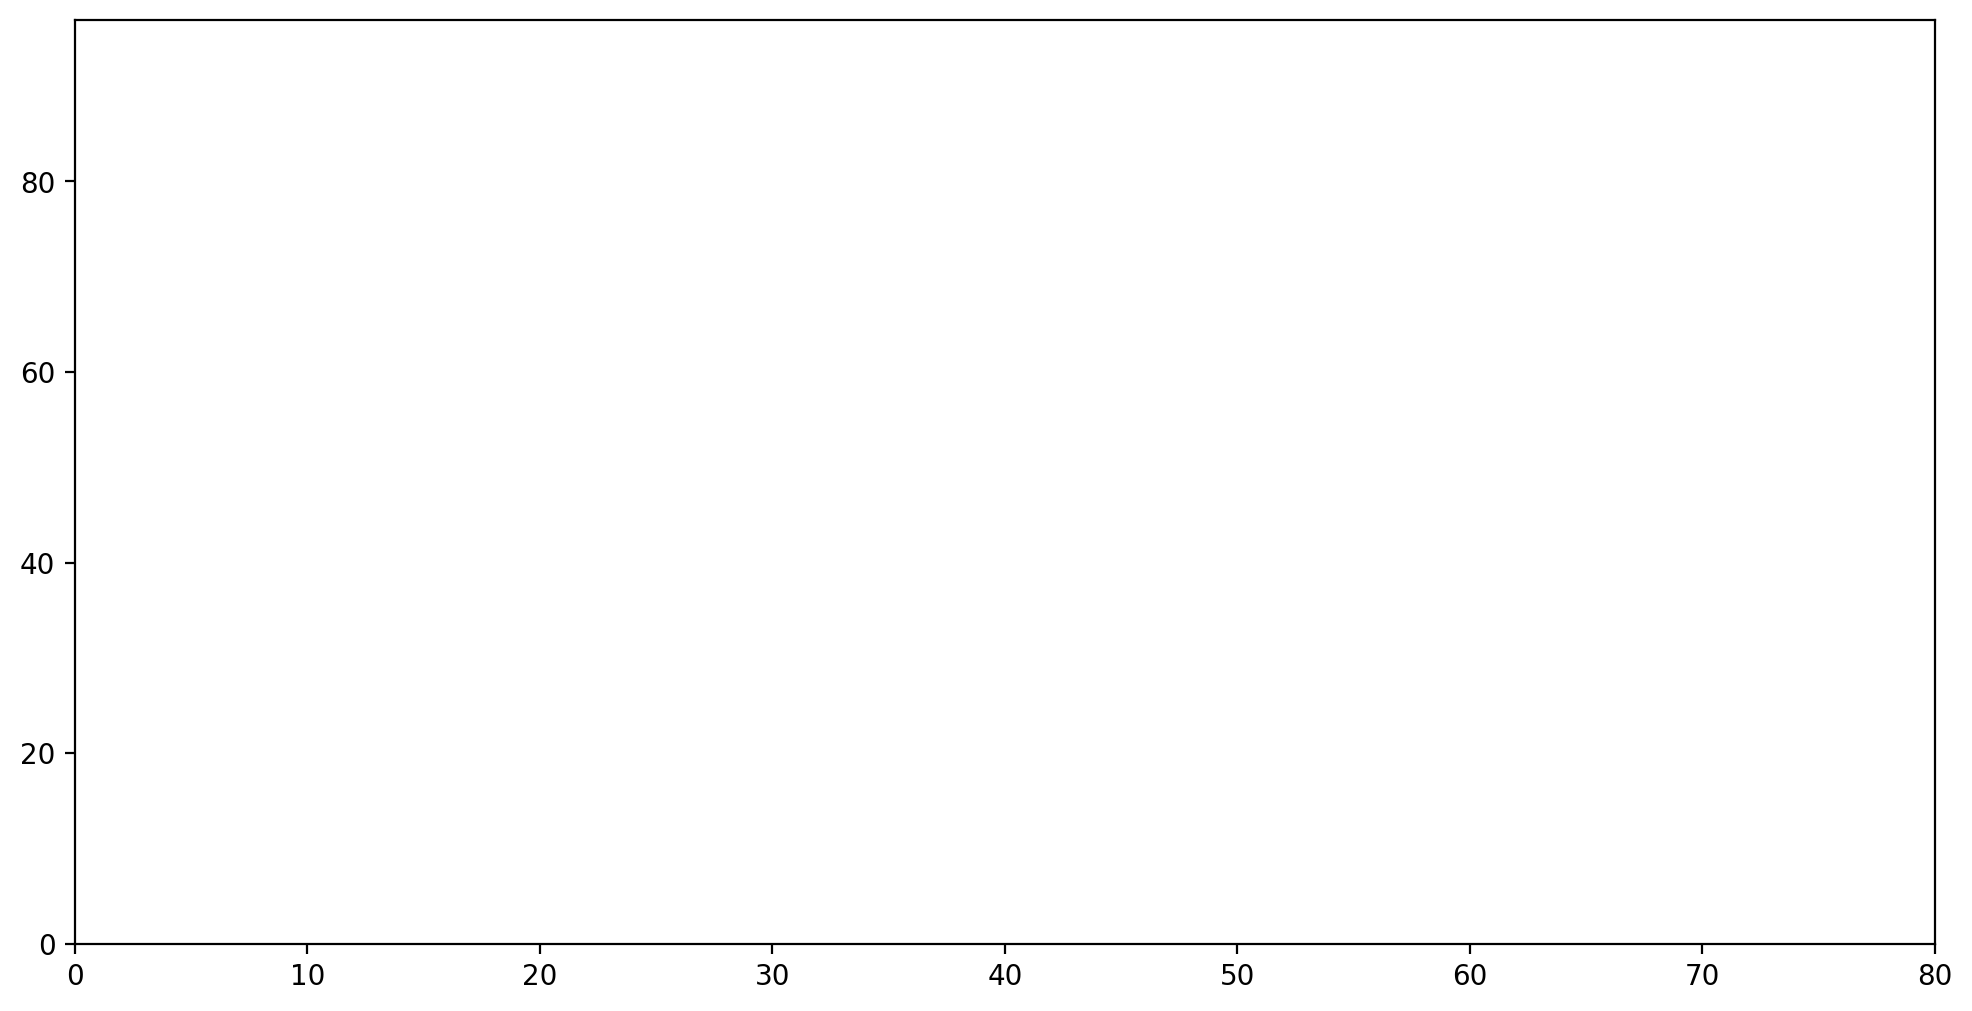

In [ ]:
import matplotlib.pyplot as plt
plt.pcolormesh(ds_sst.isel(time=0).tos.values-tfit.isel(time=0).tos.values)